# Quantum Sensing Example: Optically Detected Magnetic Resonance 

## ODMR - An Overview 

Optically detected magnetic resonance (ODMR) is a common quantum sensing technique usable to detect magnetic fields at very small length scales. It has many applications ranging from quality control of miniature electronics to monitoring brain activity. One of the most popular quantum systems used for ODMR is the nitrogen-vacancy (NV) centre in diamond. You can find a cool animation of NV-ODMR [here](https://www.youtube.com/watch?v=VCT0wDLyvSs).

In this workshop, we will simulate ODMR using an (overly) simplified model of the NV centre. If you are interested in its detailed anatomy, see [here](https://www.sciencedirect.com/science/article/abs/pii/S0370157313000562).

#### How ODMR works
Let's bring our attention to the NV model in the (LHS of the) figure below.
- It has optical excited and ground states ($|e\rangle$ and $|g\rangle$). Each of these has three possible spin states ($|1\rangle$, $|0\rangle$ and $|{-1}\rangle$). 
- We can incoherently pump the system from $|e\rangle\to|g\rangle$, while preserving the spin, using green light.
- These excitations can then radiatively decay back to $|g\rangle$, while preserving the spin, emitting red photons.
- The excitations in spin $|{\pm1}\rangle$ states can also take an alternative nonradiative decay pathway, where no photons are emitted. 
- Therefore, the NV centre will glow brighter in red when it is in the spin $|0\rangle$ state, and darker when in the $|{\pm1}\rangle$ states.

Let's now zoom in to the ground spin subsystem (lower right inset).
- We can drive coherent spin transitions between $|0\rangle\leftrightarrow|{\pm1}\rangle$ using microwave fields.
- In the absence of any dc magnetic fields, $|{\pm1}\rangle$ spin states will have the same energy (degenerate).
- When you shine a dc magnetic field (B) along the N-V axis, the $|{\pm1}\rangle$ states separate, with an energy gap proportional to B. We call this _Zeeman splitting_.
- When the frequency of the microwave field correctly matches the $|0\rangle\to|{1}\rangle$ or $|0\rangle\to|{-1}\rangle$ transitions, we will significantly populate these _'dark'_ states, which will appear as steep drops in red photon counts in the ODMR spectrum (upper right inset).
- We can measure the distance between the ODMR dips and convert it to B.

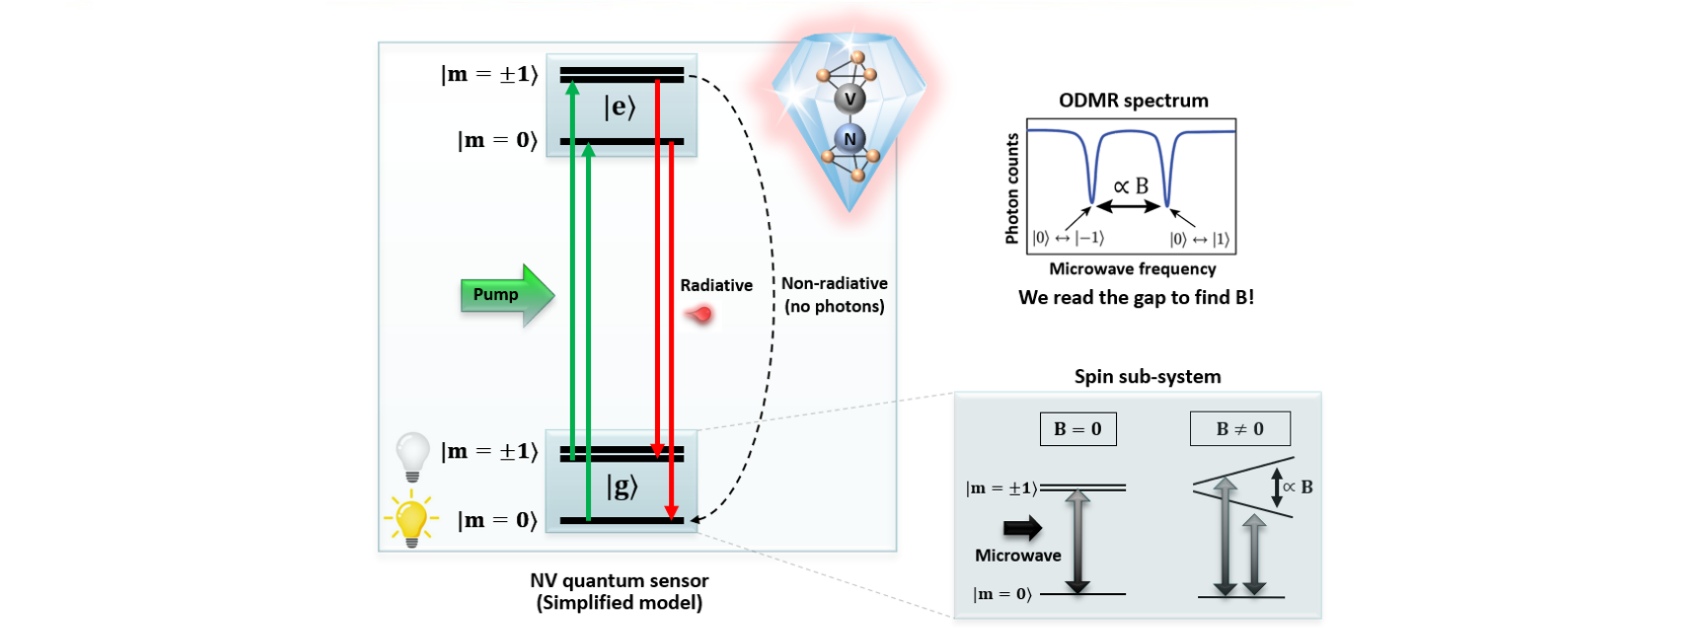


## Overview of the simulation procedure

We will first learn how to simulate the following steps using basic methods in Python:
1. [Building the basis of the composite system](#basis)
2. [Composite system Hamiltonian](#Hamiltonian)
3. [Environmental interactions](#c_ops)
4. [Evolving the system until steady state](#evolution)
5. [Generating ODMR spectra](#ODMR)

We will then [repeat the process using QuTiP](#Qutip_sim).

## 1. Building the basis of the composite system<a class="anchor" id="basis"></a>

Our simplified NV model has an optical sub-system with dimension $d_\text{op} = 2$ and a spin subsystem with dimention $d_\text{s}=3$.

- Basis for optical sub-system: $\left\lbrace|g\rangle=\begin{pmatrix} 1\\ 0 \end{pmatrix}, |e\rangle=\begin{pmatrix} 0\\ 1 \end{pmatrix}\right\rbrace$<br><br>
- Basis for spin sub-system: $\left\lbrace|{+1}\rangle=\begin{pmatrix} 1\\ 0 \\0 \end{pmatrix}, |0\rangle = \begin{pmatrix} 0\\ 1 \\0 \end{pmatrix}, |{-1}\rangle=\begin{pmatrix} 0\\ 0 \\1 \end{pmatrix}\right\rbrace$.


In [1]:
import numpy as np

basis_op = np.eye(2)   # Basis for optical sub-system (2x2 identity)
basis_m = np.eye(3)    # Basis for spin sub-system (3x3 density matrix)

<br>
To easily access basis states of subsystems, let's arrange them into dictionaries:

In [2]:
# Building spin basis vector dictionary
m_keys = ['+1', '0', '-1']                              # keys of the spin dictionary
m_vals = [basis_m[m].reshape((3,1)) for m in range(3)]  # states (a colunm vector for each basis state)
ket_m = dict(zip(m_keys, m_vals))                       

# Building optical basis vector dictionary
op_keys = ['g', 'e']
op_vals = [np.array([[1], [0]]), np.array([[0],[1]])]
ket_op = dict(zip(op_keys, op_vals))

## 2. Composite system Hamiltonian<a class="anchor" id="Hamiltonian"></a>

Let us assume that a microwave field $B_\mu=B_{\mu0}\cos(\omega_\mu t)$ is interacting with only the ground spin subsystem of the NV centre. For simplicity, we estimate the composite NV Hamiltonian as:

$$H_\text{NV} \sim |g\rangle\langle g|\otimes H_\text{gs}$$<br>
$$\text{where the ground state spin Hamiltonian is given by,}$$
$$H_\text{gs} = \underbrace{(\omega_{g+1}-\omega_\mu) |1\rangle\langle 1| + (\omega_{g-1}-\omega_\mu) |{-1}\rangle\langle {-1}|}_{H_\text{gs0}\text{ (Unperturbed part)}} + \underbrace{\lbrace\overbrace{\Omega_\mu\left(  |0\rangle\langle 1| + |0\rangle\langle -1| \right)}^{M}+ h.c.\rbrace}_{H_\text{int}\text{ (Microwave interaction)}}$$.

In the above; 
- The eigen-energies of $|{\pm1}\rangle$ (in angular frequency units) are given by $\omega_{g\pm1} = 2\pi D_\text{gs} \pm \left(\frac{g\mu_B}{\hbar}\right)B$, where $B$ is the dc magnetic field we aim to measure. 
- $\Omega_\mu = \left(g\mu_B B_{\mu0}\right)\left(2\sqrt{2}\hbar\right)$ is the spin population oscillation (or _Rabi_) frequency.
- We used $+$ $h.c.$ to denote **Hermitian conjugation** ($\dagger$) of the preceding expression $M$, as in $M \to M^\dagger = (M^*)^T =  (M^T)^*$.

In [3]:
# Values of constants and parameters
g = 2.0                           # Lande g-factor
mu_B = 9.2740100783e-24           # Bohr magneton in SI (J/T)
h_bar = 1.054571817e-34           # Reduced Plank's constant in J.s
D_gs = 2.87e9                     # NV zero-field splitting parameter

Hamiltonian builder function

In [4]:
# The function get_H_NV() outputs: Hamiltonian H_NV in rad/s units
# Inputs:
# B     ---> Static magnetic field (in T)
# B_mu0 ---> Amplitude of the microwave field (in T)
# om_mu ---> Microwave frequency (in rad/s units)

def get_H_NV(B, B_mu0, om_mu):
    # Unperturbed ground state Hamiltonian (@ denotes matrix multiplication)
    fac = (g*mu_B)/h_bar
    om_g_plus1 = 2*np.pi*D_gs +  fac*B
    om_g_min1 = 2*np.pi*D_gs -  fac*B
    H_gs0 = (om_g_plus1 - om_mu) * ket_m['+1'] @ ket_m['+1'].T  + (om_g_min1 - om_mu) * ket_m['-1'] @ ket_m['-1'].T 
    
    # Microwave-spin interaction Hamiltonian
    Omega_mu = (g*mu_B*B_mu0) / (2*np.sqrt(2)*h_bar)
    M = Omega_mu * (ket_m['0'] @ ket_m['+1'].T  + ket_m['0'] @ ket_m['-1'].T)    
    H_int =  M + M.conj().T
    
    # Ground state spin Hamiltonian
    H_gs = H_gs0 + H_int
    
    # Composite Hamiltonian
    g_op = ket_op['g'] @ ket_op['g'].T
    H_NV = np.kron(g_op, H_gs)  
    
    return H_NV

## 3. Environmental interactions<a class="anchor" id="c_ops"></a>

In our simplified NV-ODMR abstraction, we model the pumping, radiative decay, and nonradiative decay between the optical subsystem as incoherent environmental interactions (that gradually fade away the system's quantum coherence or its well-defined phase information). Such incoherent interactions can be mathematically defined using **Lindblad** (also known as _collapse_ or _jump_) operators. 

Let us construct the Lindblad operators for each of the above interactions as follows:
- Spin preserving optical pumping: $\mathbf{L}_{p,m} = \left(|e\rangle\otimes|m\rangle\right)\left(\langle g|\otimes\langle m|\right)$, for $m\in\lbrace+1, 0,-1\rbrace$
- Spin preserving radiative decay: $\mathbf{L}_{\text{rad},m} = \left(|g\rangle\otimes|m\rangle\right)\left(\langle e|\otimes\langle m|\right)$, for $m\in\lbrace+1, 0,-1\rbrace$
- Spin flipping nonradiative decay: $\mathbf{L}_{\text{nr},m} = \left(|g\rangle\otimes|0\rangle\right)\left(\langle e|\otimes\langle m|\right)$, for $m\in\lbrace+1, -1\rbrace$

which happen at rates $\mathbf{\Gamma}_{p,m}$, $\mathbf{\Gamma}_{\text{rad},m}$, $\mathbf{\Gamma}_{\text{nr},m}$, respectively.  In practice we will re-absorb the rates in the definition of the Lindblad operators:
$L_k \to \tilde{L}_k = \sqrt{\gamma_k} L_k$

Let us make a list of all collapse operators with the rates embedded. The order is not important.

In [5]:
# Initialise empty list
c_ops = []

# Common rates
Gamma_p = 1e6
Gamma_rad = 100e6
Gamma_nr = 5e6

for m in m_keys:
    
    # Construct and append pump operator to list
    L_pm = np.sqrt(Gamma_p) * np.kron(ket_op['e'], ket_m[m]) @ np.kron(ket_op['g'], ket_m[m]).conjugate().T
    c_ops.append(L_pm)
    
    # Construct and append radiative decay operator to list
    L_radm = np.sqrt(Gamma_rad) * np.kron(ket_op['g'], ket_m[m]) @ np.kron(ket_op['e'], ket_m[m]).conjugate().T
    c_ops.append(L_radm)
    
    # Construct and append radiative decay operator to list (applies only for +/- spin states)
    if m != '0':
        L_nrm = np.sqrt(Gamma_nr) * np.kron(ket_op['g'], ket_m['0']) @ np.kron(ket_op['e'], ket_m[m]).conjugate().T
        c_ops.append(L_nrm)

## 4. Evolving the system until steady state<a class="anchor" id="evolution"></a>

We can estimate the time evolution of our open quantum system (NV centre interacting with the environment) using the _Lindblad_ master equation,
$$\dot{\rho} = -i [H_\text{NV},\rho] + \sum_{k} \Gamma_k \bigg(L_k\rho L_k^\dagger - \frac{1}{2}\{L_k^\dagger L_k,\rho\}\bigg)$$
where 
- $\rho$ is the density operator representing the open quantum system's state (which is being evolved). 
-  $H_\text{NV}$, $L_k$, and $\Gamma_k$, are the composite Hamiltonian, collapse operators, and corresponding rates defined earlier.

An easy way to directly solve for the steady state of a low-dimensional linear quantum system is to get the null-space of its Liouville superoperator (see [here](https://arxiv.org/pdf/2303.16449.pdf) for details). That is, if we vectorise the density matrix in column-order (stacking one column after another), we can write the Lindblad master equation in its **column-ordered** superoperator form as;
$$\dot{\vec{\rho}} = \mathcal{L}\vec{\rho}$$
where $\vec{\rho}$ is the vectorised density matrix and $\mathcal{L} = -i\Big(\mathbb{1} \otimes H - H^\mathrm{T}\otimes\mathbb{1}\Big) + \sum_k\Gamma_k \bigg[ L_k^*\otimes L_k- \frac{1}{2} \Big(\mathbb{1}\otimes L_k^\dagger L_k + L_k^\mathrm{T} L_k^*\otimes\mathbb{1}\Big)\bigg]$.

The steady state $\vec{\rho}_{ss}$ satifies $\dot{\vec{\rho}}_{ss} = \mathcal{L}\vec{\rho}_{ss} = 0$. 

Therefore, by solving for the **null-space** of the of the superoperator $\mathcal{L}$ (the set of all states which $\mathcal{L}$ maps to the zero state), we can get the steady state density matrix in its column ordered vector form. If the dimension of the null-space is 1 there is only one possible steady state.


In [6]:
# import null space method
from scipy.linalg import null_space


# The function get_rho_ss() outputs: the steady state density matrix (assuming a unique solution)
# Inputs:
# H     ---> Hamiltonian
# c_ops ---> The list of collapse operators with rates embedded

def get_rho_ss(H, c_ops):
    d = len(H)              # dimension of the system
    I_d = np.eye(d)         # Identity operator of dimension d
    superH = -1j * (np.kron(I_d, H) - np.kron(H.T, I_d))
    superL = sum([np.kron(L.conjugate(), L) - (1/2)*(np.kron(I_d, L.conjugate().T @ L) 
                                                     + np.kron(L.T @ L.conjugate(), I_d)) for L in c_ops])
    
    superop = superH + superL
    vec_rho_ss = null_space(superop)                   # Obtain the vectorised steady state density operator
    rho_ss = np.reshape(vec_rho_ss, (d,d), order='F')  # Reshape into a matrix in the column ordered form (order='F')
    rho_ss = rho_ss/np.trace(rho_ss)                   # Normalise
    
    return rho_ss

## 5. Generating ODMR spectra<a class="anchor" id="ODMR"></a>

Total photon emission rate can be estimated as $R = \sum_{m=-1}^{+1}\Gamma_\text{rad}\times\rho_{em, em}\propto\sum_{m=-1}^{+1}\rho_{em, em}$

where, $\rho_{em, em}$ is the probability of finding the system is the $m^\text{th}$ spin state of $|e\rangle$, and $\Gamma_\text{rad}$ is the rate of photon emission from the state $|e,m\rangle\to|g,m\rangle$, $\forall$ $m$.

<IPython.core.display.Javascript object>


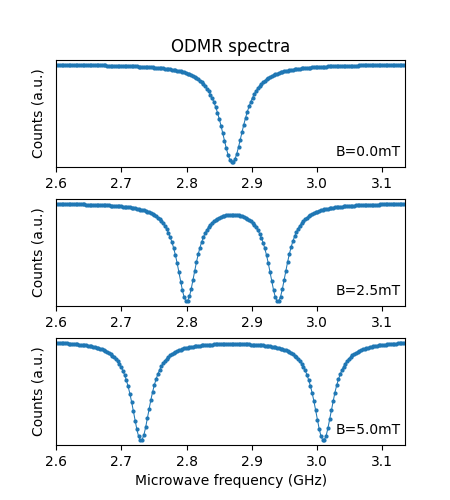

In [7]:
import matplotlib.pyplot as plt
%matplotlib notebook

fig, ax = plt.subplots(3,1, figsize=(4.5,5))
plt.subplots_adjust(hspace=0.3)

B_vec = np.array([0, 2.5, 5])*1e-3          # Magnetic field to be measured (in T)       
for idx,B in enumerate(B_vec):
    
    B_mu0 = 0.2e-3                           # Mocrowave amplitude
    vec_GHz = np.linspace(2.6, 3.135, 200)   # Microwave frequency vector in GHz
    om_mu_vec = 2*np.pi * vec_GHz * 1e9      # Microwave frequency vector in rad/s
    pop_e_vec = []                           # Initialise empty array to store populations
    
    for om_mu in om_mu_vec:
        H_NV = get_H_NV(B, B_mu0, om_mu)
        rho_ss = get_rho_ss(H_NV, c_ops)
        pop_e = sum([np.diag(rho_ss)[3+i] for i in range(3)]) # Total excited state population (for all spin states) 
        pop_e_vec.append(pop_e)
        
    ax[idx].plot(vec_GHz, np.real(pop_e_vec), '.-', linewidth=0.75, markersize=4)
    ax[idx].text(0.80, 0.10, 'B='+str(B*1e3)+'mT', transform = ax[idx].transAxes)
    ax[idx].set_ylabel('Counts (a.u.)')
    ax[idx].get_yaxis().set_ticks([])
    ax[idx].set_xlim(vec_GHz[0], vec_GHz[-1])
    
ax[0].set_title('ODMR spectra')
ax[2].set_xlabel('Microwave frequency (GHz)');

## Repeating the procedure using [Qutip](https://qutip.org/)<a class="anchor" id="Qutip_sim"></a>
(Same parameters as in the section above apply)

<IPython.core.display.Javascript object>


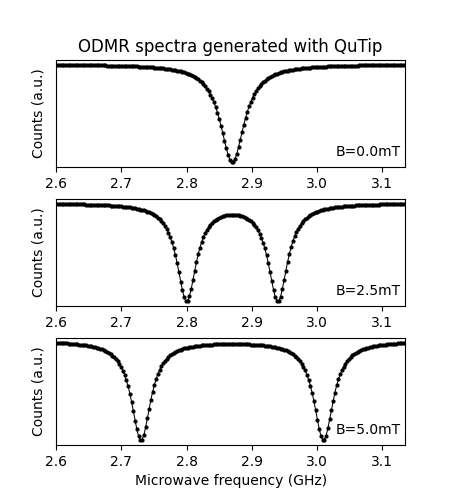

In [8]:
import qutip as qt


# Building spin basis dictionary
m_keys = ['+1', '0', '-1']                               
m_vals = [qt.basis(3, m_idx) for m_idx in range(3)]         
ket_m = dict(zip(m_keys, m_vals))                     


# Building optical basis dictionary
op_keys = ['g', 'e']
op_vals = [qt.basis(2, m_idx) for m_idx in range(2)]
ket_op = dict(zip(op_keys, op_vals))


# Hamiltonian builder function
def get_H_NV_q(B, B_mu0, om_mu):
    fac = (g*mu_B)/h_bar
    om_g_plus1 = 2*np.pi*D_gs +  fac*B
    om_g_min1 = 2*np.pi*D_gs -  fac*B
    H_gs0 = (om_g_plus1 - om_mu) * qt.ket2dm(ket_m['+1']) + (om_g_min1 - om_mu) * qt.ket2dm(ket_m['-1'])   
    Omega_mu = (g*mu_B*B_mu0) / (2*np.sqrt(2)*h_bar)
    M = Omega_mu * (ket_m['0'] * ket_m['+1'].dag()  + ket_m['0'] * ket_m['-1'].dag())    
    H_int =  M + M.dag()
    H_gs = H_gs0 + H_int
    g_op = qt.ket2dm(ket_op['g'])      # ket2dm obtains the outer product
    H_NV = qt.tensor(g_op, H_gs)    # Composite Hamiltonian
    return H_NV


# Building the collapse operator list
C_ops = []  
for m in m_keys:
    L_pm = np.sqrt(Gamma_p) * qt.tensor(ket_op['e'], ket_m[m]) * qt.tensor(ket_op['g'], ket_m[m]).dag()
    C_ops.append(L_pm)
    L_radm = np.sqrt(Gamma_rad) * qt.tensor(ket_op['g'], ket_m[m]) * qt.tensor(ket_op['e'], ket_m[m]).dag()
    C_ops.append(L_radm)
    if m != '0':
        L_nrm = np.sqrt(Gamma_nr) * qt.tensor(ket_op['g'], ket_m['0']) * qt.tensor(ket_op['e'], ket_m[m]).dag()
        C_ops.append(L_nrm)
        

# Solving using qutip steadystate() function and plotting the spectra again
fig, ax = plt.subplots(3,1, figsize=(4.5,5))
plt.subplots_adjust(hspace=0.3)  
for idx,B in enumerate(B_vec):
    pop_e_vec = []                           # Initialise empty array to store populations
    for om_mu in om_mu_vec:
        H_NV_q = get_H_NV_q(B, B_mu0, om_mu)
        rho_ss = qt.steadystate(H_NV_q, C_ops)
        pop_e = sum([np.diag(rho_ss.full())[3+i] for i in range(3)]) # Total excited state population
        pop_e_vec.append(pop_e)
    ax[idx].plot(vec_GHz, np.real(pop_e_vec), 'k.-', linewidth=0.75, markersize=4)
    ax[idx].text(0.80, 0.10, 'B='+str(B*1e3)+'mT', transform = ax[idx].transAxes)
    ax[idx].set_ylabel('Counts (a.u.)')
    ax[idx].get_yaxis().set_ticks([])
    ax[idx].set_xlim(vec_GHz[0], vec_GHz[-1])

ax[0].set_title('ODMR spectra generated with QuTip')
ax[2].set_xlabel('Microwave frequency (GHz)');